#Анализ защищенности систем искусственного интеллекта
##Лабораторная работа №2
Выполнил Растегаев И.Г. ББМО-01-23

In [1]:
import kagglehub

path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Путь к датасету в среде Google Colab:", path)

100%|██████████| 612M/612M [00:07<00:00, 91.0MB/s]

Extracting files...


Путь к датасету в среде Google Colab: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [2]:
!mv /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/ /content/gtsrb

In [3]:
import torch
device = torch.device("cuda")

In [4]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Загрузка и подготовка набора данных
def load_gtsrb_data(data_dir):
    images = []
    labels = []
    for label in range(43):
        class_dir = os.path.join(data_dir, str(label))
        if not os.path.exists(class_dir):
            print(f"Папка {class_dir} не найдена. Пропускаем...")
            continue
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

data_dir = "/content/gtsrb/1/train"

# Загрузка данных
images, labels = load_gtsrb_data(data_dir)

# Разделение на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encoding меток классов
y_train = to_categorical(y_train, num_classes=43)
y_val = to_categorical(y_val, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)

print(f"Размеры: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")


Размеры: X_train=(27446, 32, 32, 3), X_val=(5881, 32, 32, 3), X_test=(5882, 32, 32, 3)


In [5]:
# Для уменьшения времени работы проведем обучение лишь на ограниченной выборке из 4000 штук
small_X_train = X_train[:4000]
small_y_train = y_train[:4000]

In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model, layers, optimizers

# Загрузка VGG16 с предобученными весами
base_updated_model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
x = layers.Flatten()(base_updated_model_vgg.output)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(43, activation="softmax")(x)

updated_model_vgg = Model(inputs=base_updated_model_vgg.input, outputs=output)

# Компиляция модели
updated_model_vgg.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Обучение
history_vgg = updated_model_vgg.fit(
    small_X_train, small_y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 515s 4s/step - accuracy: 0.0536 - loss: 3.8363 - val_accuracy: 0.0874 - val_loss: 3.4042
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 514s 4s/step - accuracy: 0.0763 - loss: 3.4182 - val_accuracy: 0.0935 - val_loss: 3.3809
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 559s 4s/step - accuracy: 0.0976 - loss: 3.2428 - val_accuracy: 0.1644 - val_loss: 2.8347
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 566s 4s/step - accuracy: 0.1578 - loss: 2.9196 - val_accuracy: 0.2338 - val_loss: 2.4567
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 564s 4s/step - accuracy: 0.2706 - loss: 2.3494 - val_accuracy: 0.3447 - val_loss: 2.0022


In [9]:
from tensorflow.keras.applications import ResNet50

# Загрузка ResNet50 с предобученными весами
base_model_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
x = layers.Flatten()(base_model_resnet.output)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(43, activation="softmax")(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=output)

# Компиляция модели
model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Обучение
history_resnet = model_resnet.fit(
    small_X_train, small_y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - accuracy: 0.2534 - loss: 3.1678 - val_accuracy: 0.0536 - val_loss: 5.0851
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.5655 - loss: 1.4853 - val_accuracy: 0.0221 - val_loss: 7.0598
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.7126 - loss: 1.0136 - val_accuracy: 0.0784 - val_loss: 8.6096
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.7992 - loss: 0.6998 - val_accuracy: 0.1296 - val_loss: 4.0284
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8150 - loss: 0.6688 - val_accuracy: 0.2676 - val_loss: 3.5592


VGG16 - Тестовая точность: 0.35, Тестовая потеря: 2.00
ResNet50 - Тестовая точность: 0.26, Тестовая потеря: 3.62


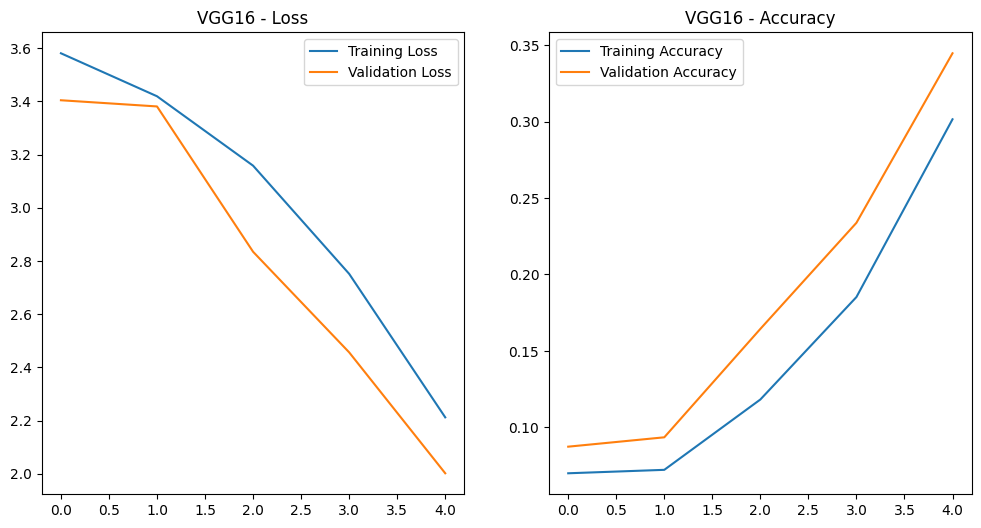

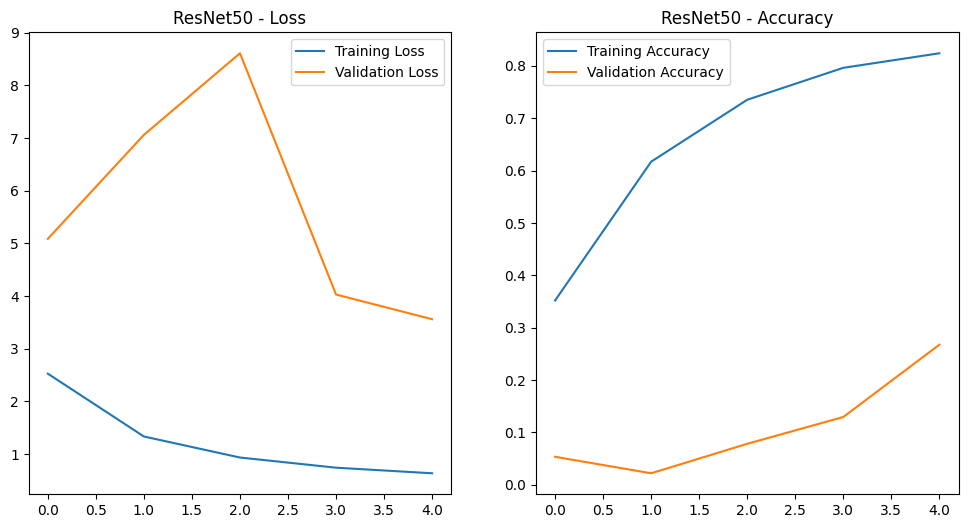

In [10]:
# Оценка моделей
vgg_eval = updated_model_vgg.evaluate(X_test, y_test, verbose=0)
resnet_eval = model_resnet.evaluate(X_test, y_test, verbose=0)

print(f"VGG16 - Тестовая точность: {vgg_eval[1]:.2f}, Тестовая потеря: {vgg_eval[0]:.2f}")
print(f"ResNet50 - Тестовая точность: {resnet_eval[1]:.2f}, Тестовая потеря: {resnet_eval[0]:.2f}")

# Построение графиков функции потерь и точности
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.show()

plot_history(history_vgg, "VGG16")
plot_history(history_resnet, "ResNet50")


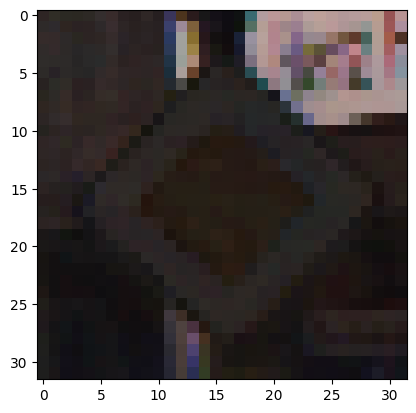

In [11]:
def modified_fgsm_attack(model, image, label, epsilon=0.01):
    image = tf.convert_to_tensor([image], dtype=tf.float32)
    label = tf.convert_to_tensor([label], dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)

    gradient = tape.gradient(loss, image)
    perturbation = epsilon * tf.sign(gradient)
    adversarial_image = tf.clip_by_value(image + perturbation, 0, 1)
    return adversarial_image[0]

# Пример атаки на одно изображение
altered_adv_image = modified_fgsm_attack(updated_model_vgg, X_test[0], y_test[0])
plt.imshow(altered_adv_image.numpy())


In [12]:
# Проверка эффективности FGSM-атак на ResNet50
for i in range(10):  # Пример из 10 изображений
    altered_adv_image = modified_fgsm_attack(updated_model_vgg, X_test[i], y_test[i])
    pred_resnet = np.argmax(model_resnet.predict(tf.convert_to_tensor([altered_adv_image])))
    true_label = np.argmax(y_test[i])
    print(f"Истинный класс: {true_label}, Предсказание ResNet50: {pred_resnet}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Истинный класс: 12, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Истинный класс: 10, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Истинный класс: 10, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Истинный класс: 25, Предсказание ResNet50: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Истинный класс: 3, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Истинный класс: 28, Предсказание ResNet50: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Истинный класс: 33, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Истинный класс: 1, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Истинный класс: 30, Предсказание ResNet50: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Истинный класс: 11, Предсказание ResNet50: 11
